<a href="https://colab.research.google.com/github/gulabpatel/ML_Algos/blob/main/Regressor%3A%20ML_Taxi_dataset_XGB_with_SKL_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### About the problem and dataset:

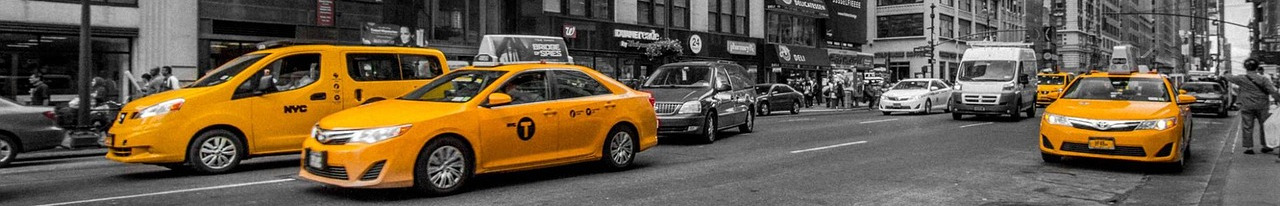

Use NYC's openly available taxi-fare dataset to predict the price of a Taxi ride. Our goal is to use XGB as the ML Framework to build a pipeline which should be capable of scaling on infinite data to make an enterprise scale model.

**Dataset**: 
15K records of NYC taxi trip including below signals:
1. pickup_community_area
2. **fare**
3. trip_start_month
4. trip_start_hour
5.   trip_start_day  
6.   trip_start_timestamp
7.   pickup_latitude     
8.   pickup_longitude    
9.   dropoff_latitude    
10.   dropoff_longitude  
11.  trip_miles          
12.  pickup_census_tract 
13.  dropoff_census_tract
14.  payment_type        
15.  company             
16.  trip_seconds        
17.  dropoff_community_area
18.  tips                  


In [ ]:
!pip install category-encoders

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import folium
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import sklearn as skl
import folium.plugins as plugins  

from sklearn.pipeline import Pipeline
from sklearn import set_config
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, FunctionTransformer, label_binarize, OneHotEncoder, KBinsDiscretizer
from sklearn.feature_extraction import FeatureHasher
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestRegressor
# from category_encoders.hashing import HashingEncoder

from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, VarianceThreshold

from folium import plugins

In [3]:
!wget https://raw.githubusercontent.com/tensorflow/tfx/master/tfx/examples/chicago_taxi_pipeline/data/simple/data.csv

--2023-01-12 05:47:19--  https://raw.githubusercontent.com/tensorflow/tfx/master/tfx/examples/chicago_taxi_pipeline/data/simple/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1922812 (1.8M) [text/plain]
Saving to: ‘data.csv’

data.csv            100%[===================>]   1.83M  --.-KB/s    in 0.06s   

2023-01-12 05:47:19 (30.9 MB/s) - ‘data.csv’ saved [1922812/1922812]



In [4]:
df = pd.read_csv('/content/data.csv')
df_orig = df.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15002 entries, 0 to 15001
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   pickup_community_area   15000 non-null  float64
 1   fare                    15002 non-null  float64
 2   trip_start_month        15002 non-null  int64  
 3   trip_start_hour         15002 non-null  int64  
 4   trip_start_day          15002 non-null  int64  
 5   trip_start_timestamp    15002 non-null  int64  
 6   pickup_latitude         15000 non-null  float64
 7   pickup_longitude        15000 non-null  float64
 8   dropoff_latitude        14519 non-null  float64
 9   dropoff_longitude       14519 non-null  float64
 10  trip_miles              15002 non-null  float64
 11  pickup_census_tract     1 non-null      float64
 12  dropoff_census_tract    10761 non-null  float64
 13  payment_type            15002 non-null  object 
 14  company                 9862 non-null 

In [5]:
#For simplicity of demonstration we are dropping NA rows and few other columns
df = df.drop(['trip_start_timestamp','trip_miles','pickup_census_tract'
              ,'dropoff_census_tract','trip_seconds','tips'
              ,'dropoff_community_area','pickup_community_area'], axis=1)
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9584 entries, 30 to 15000
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   fare               9584 non-null   float64
 1   trip_start_month   9584 non-null   int64  
 2   trip_start_hour    9584 non-null   int64  
 3   trip_start_day     9584 non-null   int64  
 4   pickup_latitude    9584 non-null   float64
 5   pickup_longitude   9584 non-null   float64
 6   dropoff_latitude   9584 non-null   float64
 7   dropoff_longitude  9584 non-null   float64
 8   payment_type       9584 non-null   object 
 9   company            9584 non-null   object 
dtypes: float64(5), int64(3), object(2)
memory usage: 823.6+ KB


### EDA - Data exploration / Hypothesis creation and testing

In [7]:
##Train test split ( Original DF )
np.random.seed(seed=2)
msk = np.random.rand(len(df)) < 0.85
traindf = df[msk]
evaldf = df[~msk]

print(len(traindf))
print(len(evaldf))

traindf.to_csv("train.csv", index=False, header=False)
evaldf.to_csv("eval.csv", index=False, header=False)

8146
1438


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


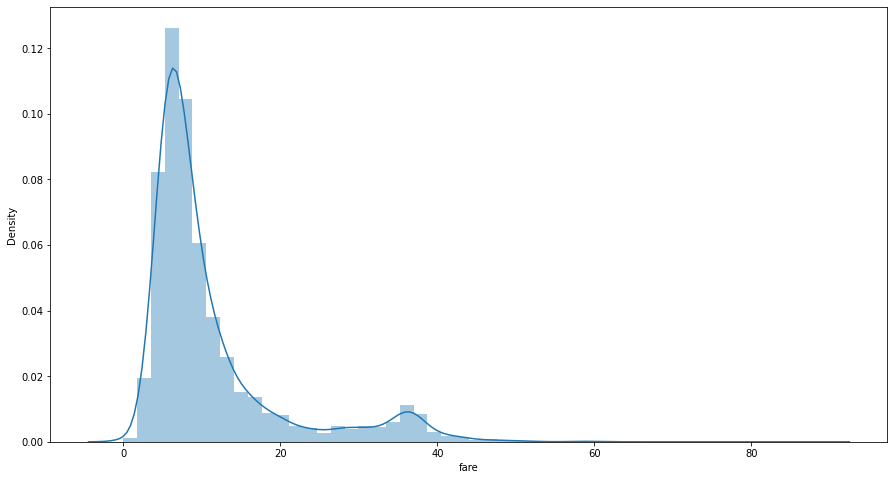

In [8]:
##Distribution of Fare
plt.figure(figsize=(15, 8))
sns.distplot(traindf['fare'])

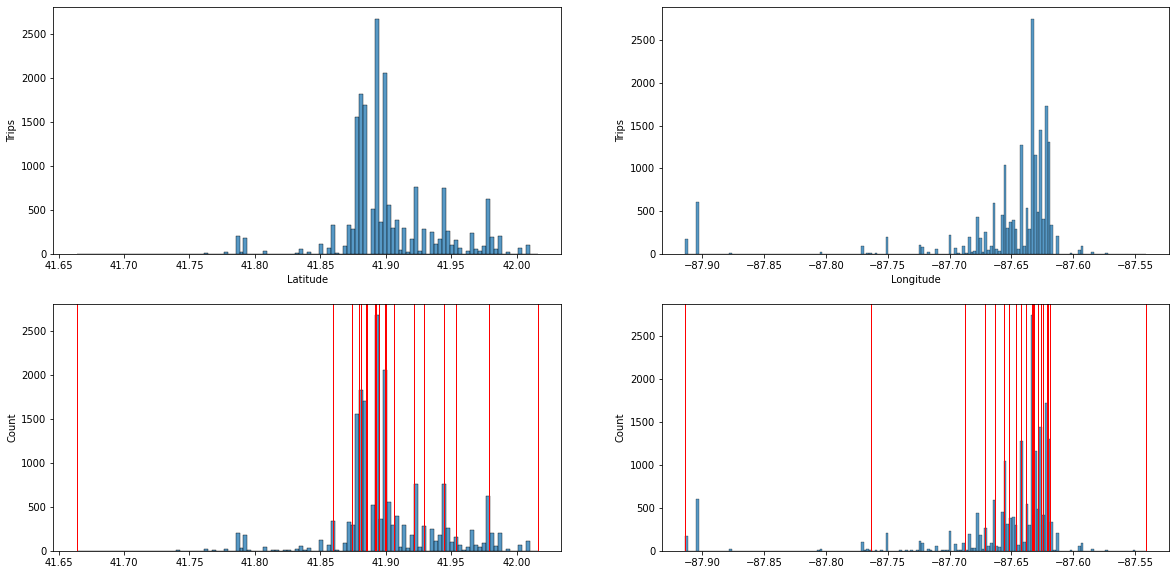

In [12]:
##Quantile Bucketization of latitude and longitude
bins_lat = pd.qcut(list(df['dropoff_latitude'].values) + list(df['pickup_latitude'].values), q=20, duplicates='drop', retbins=True)[1]
bins_lon = pd.qcut(list(df['dropoff_longitude'].values) + list(df['pickup_longitude'].values), q=20, duplicates='drop', retbins=True)[1]

#Plot all latitude values with bins
f, axes = plt.subplots(2, 2, figsize=(20, 10), sharex=False)
ax = sns.histplot(list(df['dropoff_latitude'].values) + list(df['pickup_latitude'].values), ax=axes[0, 0])
ax.set_xlabel("Latitude")
ax.set_ylabel("Trips")

ax = sns.histplot(list(df['dropoff_longitude'].values) + list(df['pickup_longitude'].values), ax=axes[0, 1])
ax.set_xlabel("Longitude")
ax.set_ylabel("Trips")

#Plot bins
sns.histplot(list(df['dropoff_latitude'].values) + list(df['pickup_latitude'].values), ax=axes[1, 0])
sns.histplot(list(df['dropoff_longitude'].values) + list(df['pickup_longitude'].values), ax=axes[1, 1])
for b_ in bins_lat:
  axes[1][0].axvline(b_, color='red', linewidth=1 )
for b_ in bins_lon:
  axes[1][1].axvline(b_, color='red', linewidth=1 )

In [13]:
##Plot locations with heatmap intensity as per the FARE
m = folium.Map()

##Add paths
locs = []
for index, row in traindf.iterrows():
  loc = locs.append(((row['pickup_latitude'], row['pickup_longitude']),
       (row['dropoff_latitude'], row['dropoff_longitude'])))

folium.PolyLine(locs,
                color='red',
                weight=0.4,
                opacity=0.1).add_to(m)

##Add heatmaps
sw = traindf[['pickup_latitude', 'pickup_longitude']].min().values.tolist()
ne = traindf[['pickup_latitude', 'pickup_longitude']].max().values.tolist()
m.add_child(plugins.HeatMap(zip(traindf['pickup_latitude'], traindf['pickup_longitude'], traindf['fare']), radius = 10))
m.add_child(plugins.HeatMap(zip(traindf['dropoff_latitude'], traindf['dropoff_longitude'], traindf['fare']), radius = 10))
m.fit_bounds([sw, ne])
m

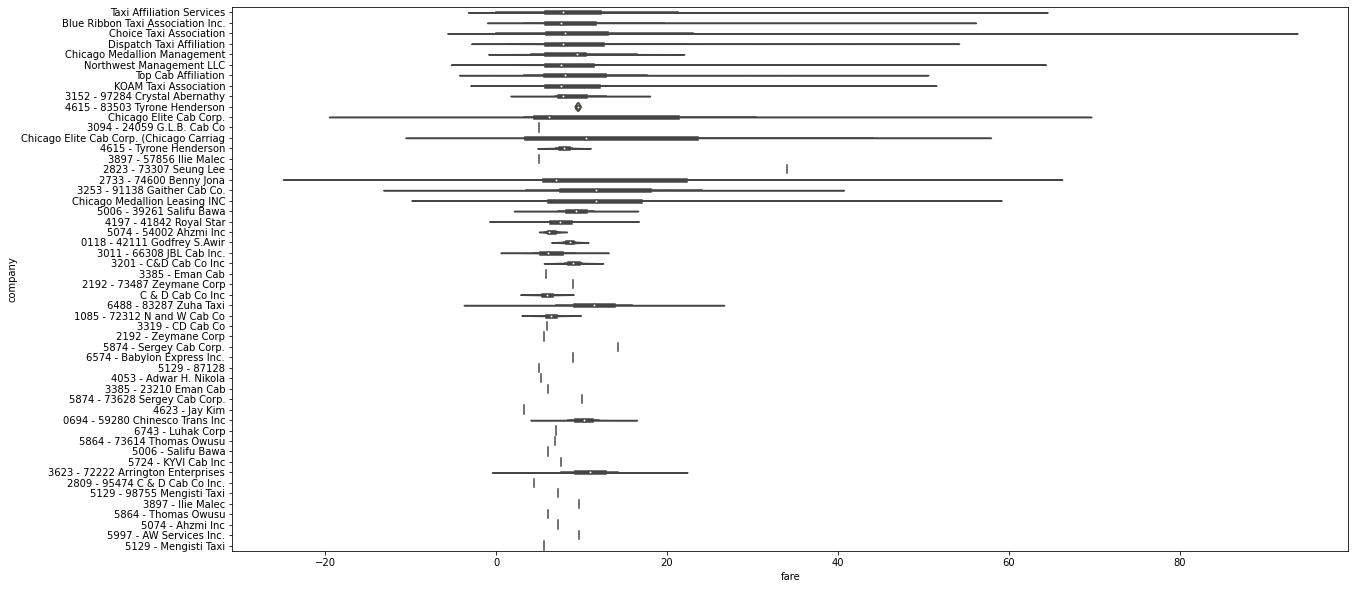

In [14]:
### Correlation of company with fare
plt.figure(figsize=(20, 10))
sns.violinplot(y=traindf['company'], x=traindf['fare'])

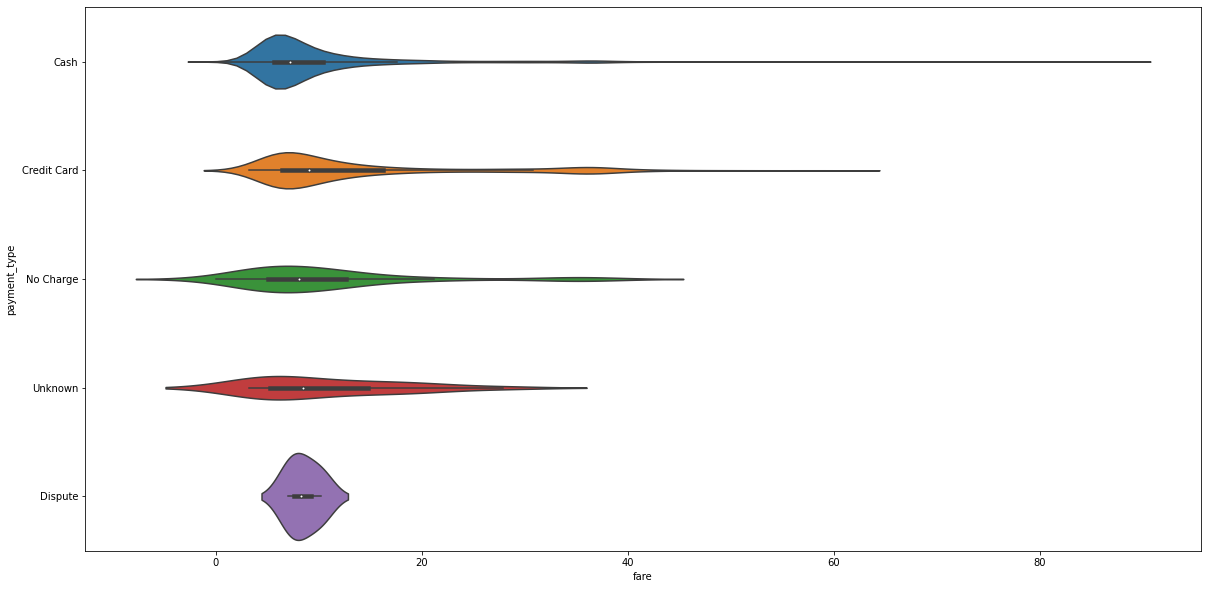

In [15]:
### Correlation of payment type with fare
plt.figure(figsize=(20, 10))
sns.violinplot(y=traindf['payment_type'], x=traindf['fare'])

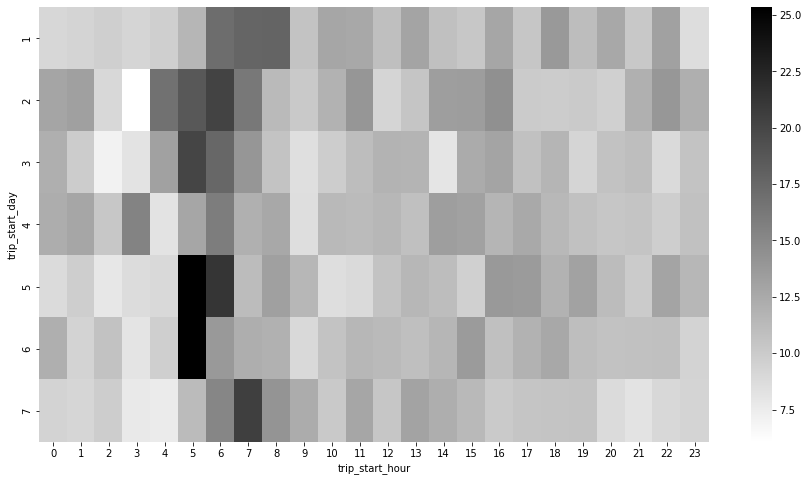

In [16]:
##Average trip fare( day & hour combined )
plt.figure(figsize=(15, 8))
cross = pd.crosstab(traindf['trip_start_day'] , pd.to_numeric(traindf['trip_start_hour']) , traindf['fare'], aggfunc=np.average)
sns.heatmap(cross, annot=False, fmt='g', cmap='binary')

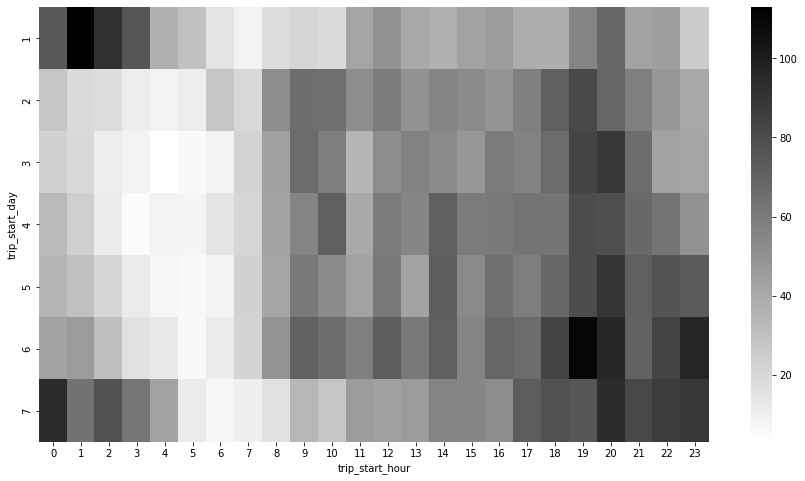

In [17]:
##Number of trips( day-hour wise )
plt.figure(figsize=(15, 8))
cross = pd.crosstab(traindf['trip_start_day'] , pd.to_numeric(traindf['trip_start_hour']) , traindf.index , aggfunc='count')
sns.heatmap(cross, annot=False, fmt='g', cmap='binary')

### Train XGB model

Basic model with just a few features( only numerical ones )

In [18]:
### Selected Features
features = ["trip_start_month", "trip_start_hour", "trip_start_day"]

In [19]:
### Split label and features
df_train_x = traindf.drop(['fare'],axis=1)
df_train_y = traindf['fare']

df_eval_x = evaldf.drop(['fare'],axis=1)
df_eval_y = evaldf['fare']

all_cols = list(df_train_x.columns)

In [20]:
### XGBoost DMatrix formatted data
dmat_train = xgb.DMatrix(df_train_x[features].values, label=df_train_y.values)
dmat_test = xgb.DMatrix(df_eval_x[features].values, label=df_eval_y.values)

In [21]:
### No CV Trainer
param = {"max_depth": 4, "objective": "reg:squarederror"} ## https://xgboost.readthedocs.io/en/stable/parameter.html#xgboost-parameters
num_round = 100

bst = xgb.train(param, 
                dmat_train, 
                num_boost_round=num_round, ## Max iterations
                early_stopping_rounds = 7,  ## Early stopping to prevent overfitting
                evals=[(dmat_test, "eval")])

[0]	eval-rmse:11.7399
Will train until eval-rmse hasn't improved in 7 rounds.
[1]	eval-rmse:10.4452
[2]	eval-rmse:9.73951
[3]	eval-rmse:9.37436
[4]	eval-rmse:9.1895
[5]	eval-rmse:9.0923
[6]	eval-rmse:9.03266
[7]	eval-rmse:9.00956
[8]	eval-rmse:8.99598
[9]	eval-rmse:8.98592
[10]	eval-rmse:8.9827
[11]	eval-rmse:8.98233
[12]	eval-rmse:8.98284
[13]	eval-rmse:8.97757
[14]	eval-rmse:8.97541
[15]	eval-rmse:8.97424
[16]	eval-rmse:8.97784
[17]	eval-rmse:8.982
[18]	eval-rmse:8.97631
[19]	eval-rmse:8.97291
[20]	eval-rmse:8.97659
[21]	eval-rmse:8.98184
[22]	eval-rmse:8.98163
[23]	eval-rmse:8.98617
[24]	eval-rmse:8.97864
[25]	eval-rmse:8.97909
[26]	eval-rmse:8.97903
Stopping. Best iteration:
[19]	eval-rmse:8.97291



In [22]:
### Evaluate model
pred_eval_y = bst.predict(dmat_test)
print("rmse: {}".format(mean_squared_error(pred_eval_y, df_eval_y) ** 0.5))

rmse: 8.979034053844146


In [23]:
bst.get_fscore()

{'f1': 162, 'f2': 123, 'f0': 120}

### Train XGB model

With Many features - SKL Pipeline based
+ Including HPT with Grid search
+ Including feature engineering

In [24]:
# ### CV Trainer
# param = {"max_depth": 4, "objective": "reg:squarederror"} ## https://xgboost.readthedocs.io/en/stable/parameter.html#xgboost-parameters
# num_round = 100

# xgb.cv(param, 
#        dmat_train, 
#        num_round, 
#        nfold=10,
#        metrics={'rmse'},
#        early_stopping_rounds = 100
#        ) ## Early stopping to prevent overfitting

In [25]:
numerical_features = ["trip_start_month", "trip_start_hour", "trip_start_day"]
categorical_features = ['company', "trip_start_month", "trip_start_hour", "trip_start_day",]
bucketized_features = ['pickup_latitude', 'pickup_longitude','dropoff_latitude', 'dropoff_longitude']

In [26]:
#Transformer to select columns from DF
def select_col_df(df_passed, col):
  return df_passed[[col]]

###Feature engineering functions
def feat_distance(df_passed):
  df_passed['distance'] = ((df_passed['pickup_latitude'] - df_passed['dropoff_latitude']) ** 2 + (df_passed['pickup_longitude'] - df_passed['dropoff_longitude']) ** 2) ** 0.5
  return df_passed[['distance']]

def feat_catcross_day_hour(df_passed):
  df_passed["trip_start_hour_copy"] = df_passed["trip_start_hour"].astype(str)
  df_passed["trip_start_day_copy"] = df_passed["trip_start_day"].astype(str)
  df_passed["catcross_day_hour"] =  df_passed["trip_start_hour_copy"] + ", " + df_passed["trip_start_day_copy"]

  return df_passed[['catcross_day_hour']]

In [27]:
## Build SKL Pipeline
#Step 1 -> Select all columns
cols = {}
for x in numerical_features + categorical_features + bucketized_features:
  if x in numerical_features:
    cols[x + "_num"] = Pipeline([('select_column', FunctionTransformer(select_col_df,kw_args={'col': x}))])
  if x in categorical_features:
    cols[x + "_categ"] = Pipeline([('select_column', FunctionTransformer(select_col_df,kw_args={'col': x}))])
  if x in bucketized_features:
    cols[x + "_bucket"] = Pipeline([('select_column', FunctionTransformer(select_col_df,kw_args={'col': x}))])

#Step -> Feature engineering -> Dynamic calling of feature engineering function
for feature in ['distance', 'catcross_day_hour']:
  cols[feature] = Pipeline([
                                  ('feat_' + feature, 
                                   FunctionTransformer(globals()["feat_" + feature]))
                          ])

#Step -> Apply Categorical encoding for categorical variables
for x in categorical_features:
  cols[x + "_categ"] = Pipeline([
                          ('enc_sel', cols[x + "_categ"]),
                          ('enc_run',OneHotEncoder(handle_unknown='ignore'))
            ])
  
#Step -> Apply KBinDiscretization for Bucket variables
for x in bucketized_features:
  cols[x + "_bucket"] = Pipeline([
                          ('enc_sel', cols[x + "_bucket"]),
                          ('enc_run',KBinsDiscretizer())
            ])
  
#Step -> Apply categorical crossing( for features starting with catcross_ )
for x in cols.keys():
  if x.startswith("catcross_"):
    cols[x] = Pipeline([
                            ('enc_sel', cols[x]),
                            ('enc_run',OneHotEncoder(handle_unknown='ignore'))
                            # ('enc_run',HashingEncoder(n_components=3))
              ])

#Step -> Union all selected columns
union = FeatureUnion([
                      (col_, cols[col_]) for col_ in list(cols.keys())  
        ])

#Step -> Add estimator
estim = Pipeline(steps = [
                        ('features',union),
                        ('regressor', xgb.XGBRegressor(random_state = 42,
                                                        n_jobs=-1,
                                                        objective="reg:squarederror",
                                                        num_boost_round=100, ## Max iterations
                                                        early_stopping_rounds = 7,  ## Early stopping to prevent overfitting
                                                        verbosity = 1
                                                        ))
                  ])

#Step -> Wrap estimator with Grid Search + CV
#Naming convention >> "regressor__<param>"
grid = {'regressor__n_estimators': [20, 30],
        'regressor__max_depth' : [2, 4, 6]}
cv_pipeline = GridSearchCV(estim, grid, scoring = 'neg_root_mean_squared_error', verbose=3)

In [28]:
### Visualize pipeline
set_config(display="diagram")
cv_pipeline

GridSearchCV(estimator=Pipeline(steps=[('features',
                                        FeatureUnion(transformer_list=[('trip_start_month_num',
                                                                        Pipeline(steps=[('select_column',
                                                                                         FunctionTransformer(func=<function select_col_df at 0x7ff8f6e48430>,
                                                                                                             kw_args={'col': 'trip_start_month'}))])),
                                                                       ('trip_start_month_categ',
                                                                        Pipeline(steps=[('enc_sel',
                                                                                         Pipeline(steps=[('select_column',
                                                                                                          FunctionTransformer(...
                                                                                                          FunctionTransformer(func=<function feat_catcross_day_hour at 0x7ff8f70b40d0>))])),
                                                                                        ('enc_run',
                                                                                         OneHotEncoder(handle_unknown='ignore'))]))])),
                                       ('regressor',
                                        XGBRegressor(early_stopping_rounds=7,
                                                     n_jobs=-1,
                                                     num_boost_round=100,
                                                     objective='reg:squarederror',
                                                     random_state=42))]),
             param_grid={'regressor__max_depth': [2, 4, 6],
                         'regressor__n_estimators': [20, 30]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [29]:
#Run pipeline for CV to search best params
cv_pipeline.fit(df_train_x, df_train_y)

print("Best parameter (CV score=%0.3f):" % cv_pipeline.best_score_)
print(cv_pipeline.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END regressor__max_depth=2, regressor__n_estimators=20;, score=-3.493 total time=   0.2s
[CV 2/5] END regressor__max_depth=2, regressor__n_estimators=20;, score=-2.696 total time=   0.2s
[CV 3/5] END regressor__max_depth=2, regressor__n_estimators=20;, score=-3.968 total time=   0.2s
[CV 4/5] END regressor__max_depth=2, regressor__n_estimators=20;, score=-3.024 total time=   0.2s
[CV 5/5] END regressor__max_depth=2, regressor__n_estimators=20;, score=-3.917 total time=   0.2s
[CV 1/5] END regressor__max_depth=2, regressor__n_estimators=30;, score=-3.072 total time=   0.2s
[CV 2/5] END regressor__max_depth=2, regressor__n_estimators=30;, score=-2.260 total time=   0.2s
[CV 3/5] END regressor__max_depth=2, regressor__n_estimators=30;, score=-3.393 total time=   0.2s
[CV 4/5] END regressor__max_depth=2, regressor__n_estimators=30;, score=-2.645 total time=   0.2s
[CV 5/5] END regressor__max_depth=2, regressor__n_estimato

In [30]:
### Train final model on train set with best params
# Set best params
estim.named_steps['regressor'].n_estimators = cv_pipeline.best_params_["regressor__n_estimators"]
estim.named_steps['regressor'].max_depth = cv_pipeline.best_params_["regressor__max_depth"]

# Train and evaluate
mod = estim.fit(df_train_x, df_train_y)

# Evaluate on Test set
pred_eval_y = mod.predict(df_eval_x)
print("rmse: {}".format(mean_squared_error(pred_eval_y, df_eval_y) ** 0.5))

rmse: 3.2220917302773366
